In [30]:
import os,sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt

In [31]:
cd ..

/Users/alexwarfel


In [32]:
from utils.extract_fred_data import extract_fred_data
from utils.credentials import credentials

In [33]:
credentials = credentials()

In [34]:
fred_api_key = credentials['FRED API Key']
fed_funds_rate = extract_fred_data(fred_api_key,'FEDFUNDS')[0]

In [35]:
fed_funds_rate

,fedfunds
date,
1954-08-01,0.80
1954-09-01,1.22
1954-10-01,1.07
1954-11-01,0.85
1954-12-01,0.83
...,...
2023-06-01,5.06
2023-07-01,5.08
2023-08-01,5.12


<Axes: xlabel='date'>

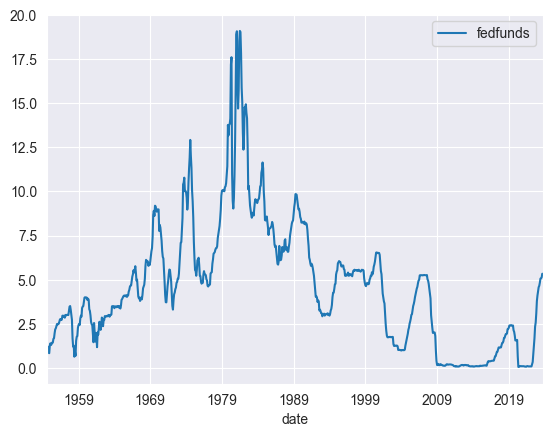

In [36]:
fed_funds_rate.plot()

In [37]:
fed_funds_rate = fed_funds_rate.round(2)

In [38]:
number_of_months = int(12*2.1)

fed_funds_rate_rolling_max = fed_funds_rate.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_reversed = fed_funds_rate.iloc[::-1]
fed_funds_rate_rolling_max_forward_reversed = fed_funds_rate_reversed.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_rolling_max_forward = fed_funds_rate_rolling_max_forward_reversed.iloc[::-1]

fed_funds_rate_peaks = fed_funds_rate[(fed_funds_rate == fed_funds_rate_rolling_max) & (fed_funds_rate == fed_funds_rate_rolling_max_forward)]

In [39]:
fed_funds_rate_peaks = pd.DataFrame(fed_funds_rate_peaks)
fed_funds_rate_peaks.columns = ['peaks']
fed_funds_rate_peaks['peaks'] = fed_funds_rate_peaks['peaks'].astype('float64')

fed_funds_rate_peaks = fed_funds_rate_peaks[fed_funds_rate_peaks['peaks'].notnull()]
fed_funds_rate_peaks

,peaks
date,
1959-12-01,4.00
1969-09-01,9.19
1974-08-01,12.92
1981-07-01,19.10
1984-09-01,11.64
1989-04-01,9.85
1995-05-01,6.05
1998-02-01,5.56
2000-08-01,6.54


In [40]:
mask = pd.Series([False] * len(fed_funds_rate_peaks), index=fed_funds_rate_peaks.index)

for i in range(len(fed_funds_rate_peaks)):
    if i == 0 or fed_funds_rate_peaks['peaks'].iloc[i] != fed_funds_rate_peaks['peaks'].iloc[i-1]:
        mask.iloc[i] = True

result_df = fed_funds_rate_peaks[mask]

result_df

,peaks
date,
1959-12-01,4.00
1969-09-01,9.19
1974-08-01,12.92
1981-07-01,19.10
1984-09-01,11.64
1989-04-01,9.85
1995-05-01,6.05
1998-02-01,5.56
2000-08-01,6.54


In [41]:
fed_funds_rate_combined = fed_funds_rate.merge(result_df, how='left', left_index=True, right_index=True)
fed_funds_rate_combined

,fedfunds,peaks
date,,
1954-08-01,0.80,NaN
1954-09-01,1.22,NaN
1954-10-01,1.07,NaN
1954-11-01,0.85,NaN
1954-12-01,0.83,NaN
...,...,...
2023-06-01,5.06,NaN
2023-07-01,5.08,NaN
2023-08-01,5.12,NaN


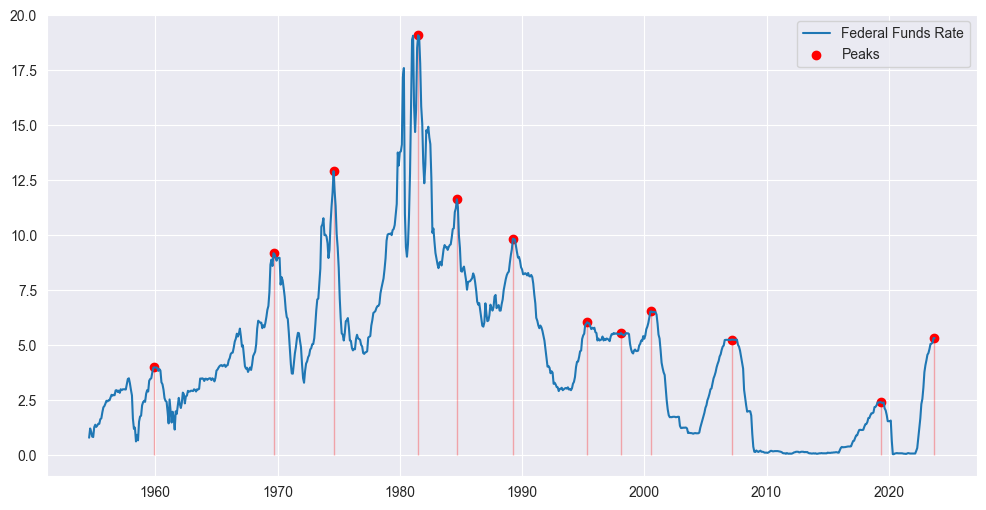

In [42]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(fed_funds_rate_combined['fedfunds'], label='Federal Funds Rate')
plt.scatter(fed_funds_rate_combined.index, fed_funds_rate_combined['peaks'], color='r', label='Peaks')
plt.fill_between(fed_funds_rate_combined.index, 0, fed_funds_rate_combined['peaks'], color='r', alpha=0.3)
plt.legend()
plt.show()


In [43]:
fed_funds_rate_combined

,fedfunds,peaks
date,,
1954-08-01,0.80,NaN
1954-09-01,1.22,NaN
1954-10-01,1.07,NaN
1954-11-01,0.85,NaN
1954-12-01,0.83,NaN
...,...,...
2023-06-01,5.06,NaN
2023-07-01,5.08,NaN
2023-08-01,5.12,NaN


In [44]:
df = fed_funds_rate_combined.copy()

percentages = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
results_df = pd.DataFrame()

peak_dates = []

for i in range(len(df)):
    if not pd.isna(df['peaks'].iloc[i]):
        peak_dates.append(df.index[i])

for percentage in percentages:
    current_results = []
    for i in range(len(df)):
        if not pd.isna(df['peaks'].iloc[i]):
            peak_value = df['peaks'].iloc[i]
            peak_date = df.index[i]
            for j in range(i+1, len(df)):
                if df['fedfunds'].iloc[j] <= peak_value * percentage:
                    months_after = (df.index[j].year - peak_date.year) * 12 + df.index[j].month - peak_date.month
                    current_results.append(months_after)
                    break  
                elif j == len(df) - 1:
                    current_results.append(None)

    current_results_df = pd.DataFrame(current_results, columns=[f'Months for rates to fall {-(percentage-1)*100:.0f}% from peak'])
    results_df = pd.concat([results_df, current_results_df], axis=1)

results_df['Peak Date'] = peak_dates

results_df.set_index('Peak Date', inplace=True)

results_df

results_df.dropna(inplace=True)

In [45]:
results_df.index = results_df.index.strftime('%b %Y')
results_df = results_df.astype('int')
results_df

,Months for rates to fall 10% from peak,Months for rates to fall 20% from peak,Months for rates to fall 30% from peak,Months for rates to fall 40% from peak,Months for rates to fall 50% from peak,Months for rates to fall 60% from peak
Peak Date,,,,,,
Dec 1959,7,9,10,13,13,14
Sep 1969,7,11,13,16,17,29
Aug 1974,2,3,5,6,7,18
Jul 1981,3,4,5,14,17,48
Sep 1984,2,4,9,21,81,88
Apr 1989,7,20,23,26,32,37
May 1995,10,43,73,77,78,79
Feb 1998,10,40,42,44,45,46
Aug 2000,7,9,10,12,14,15


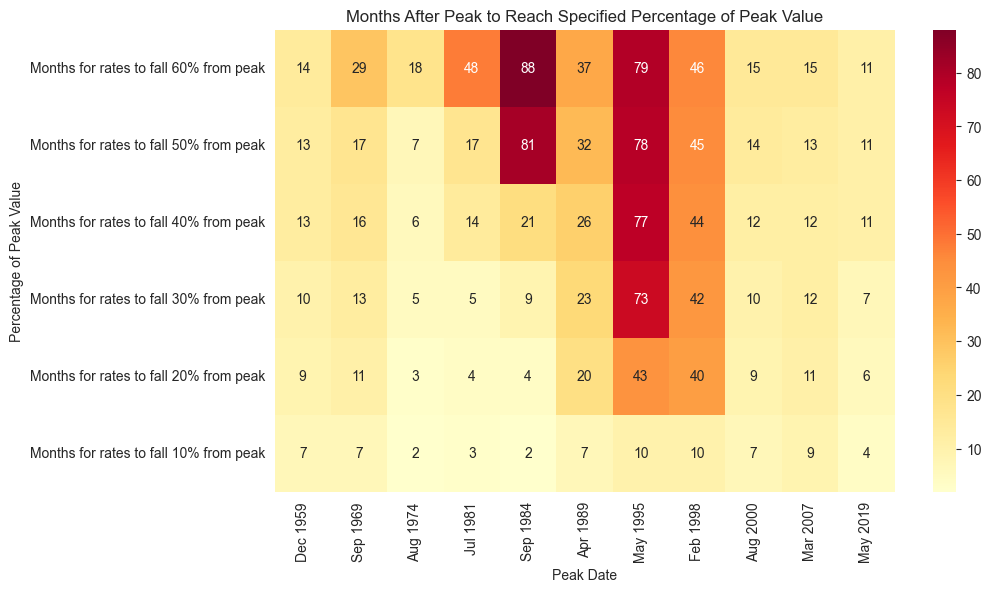

In [46]:
# Set the aesthetic style of the plots
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

reversed_df = results_df.set_index(results_df.index).T.iloc[::-1]

sns.heatmap(reversed_df, annot=True, fmt=".0f", cmap="YlOrRd")

plt.title('Months After Peak to Reach Specified Percentage of Peak Value')
plt.xlabel('Peak Date')
plt.ylabel('Percentage of Peak Value')

plt.show()

In [47]:
mean_df = pd.DataFrame(results_df.mean(), columns=['mean'])
std_df = pd.DataFrame(results_df.std(), columns=['std'])
median_std_df = pd.concat([mean_df, std_df], axis=1)
median_std_df

,mean,std
Months for rates to fall 10% from peak,6.181818,2.993933
Months for rates to fall 20% from peak,14.545455,14.151775
Months for rates to fall 30% from peak,19.000000,20.842265
Months for rates to fall 40% from peak,22.909091,20.675853
Months for rates to fall 50% from peak,29.818182,26.824683
Months for rates to fall 60% from peak,36.363636,26.759196


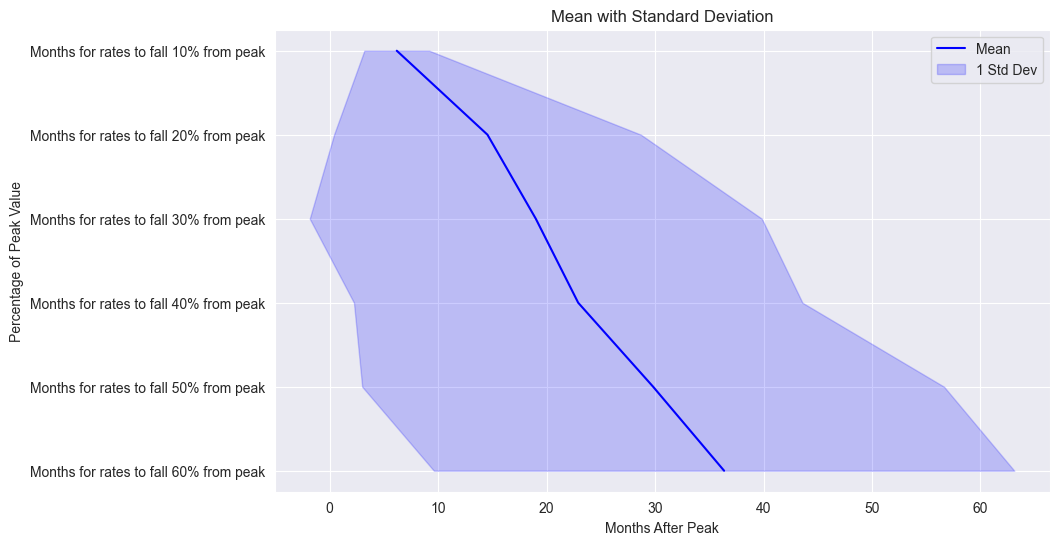

In [48]:
y = median_std_df.index

x = median_std_df['mean']

xerr = median_std_df['std']
x_upper = x + xerr
x_lower = x - xerr

plt.figure(figsize=(10,6))

plt.plot(x, y, label='Mean', color='blue')

plt.fill_betweenx(y, x_lower, x_upper, color='blue', alpha=0.2, label='1 Std Dev')

plt.title('Mean with Standard Deviation')
plt.ylabel('Percentage of Peak Value')
plt.xlabel('Months After Peak')

plt.legend()

plt.gca().invert_yaxis()

plt.show()

In [49]:
data = {
    'MEETING DATE': ['11/1/2023', '12/13/2023', '1/31/2024', '3/20/2024', '5/1/2024', '6/12/2024', '7/31/2024', '9/18/2024', '11/7/2024', '12/18/2024'],
    '350-375': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2],
    '375-400': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 2.3],
    '400-425': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 4.4, 9.7],
    '425-450': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 7.3, 15.6, 21.6],
    '450-475': [0.0, 0.0, 0.0, 0.0, 0.1, 2.5, 11.8, 22.5, 28.2, 28.4],
    '475-500': [1.1, 0.0, 0.0, 0.1, 5.3, 18.5, 30.6, 32.9, 28.5, 22.9],
    '500-525': [98.9, 0.9, 0.8, 12.7, 33.6, 39.5, 34.6, 24.9, 16.6, 11.2],
    '525-550': [0.0, 79.6, 70.7, 63.1, 46.2, 31.1, 17.6, 9.7, 5.3, 3.2],
    '550-575': [0.0, 19.5, 26.3, 22.2, 13.8, 7.9, 3.6, 1.7, 0.8, 0.5],
    '575-600': [0.0, 0.0, 2.2, 1.8, 1.1, 0.6, 0.2, 0.1, 0.0, 0.0]
}

rate_probabilities_df = pd.DataFrame(data)

rate_probabilities_df

rate_probabilities_df['MEETING DATE'] = pd.to_datetime(rate_probabilities_df['MEETING DATE'])

rate_probabilities_df['MONTHS FROM NOW'] = rate_probabilities_df['MEETING DATE'].apply(lambda x: (x.year - datetime.now().year) * 12 + x.month - datetime.now().month)

rate_probabilities_df

,MEETING DATE,350-375,375-400,400-425,425-450,450-475,475-500,500-525,525-550,550-575,575-600,MONTHS FROM NOW
0,2023-11-01,0.0,0.0,0.0,0.0,0.0,1.1,98.9,0.0,0.0,0.0,1
1,2023-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.9,79.6,19.5,0.0,2
2,2024-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.8,70.7,26.3,2.2,3
3,2024-03-20,0.0,0.0,0.0,0.0,0.0,0.1,12.7,63.1,22.2,1.8,5
4,2024-05-01,0.0,0.0,0.0,0.0,0.1,5.3,33.6,46.2,13.8,1.1,7
5,2024-06-12,0.0,0.0,0.0,0.0,2.5,18.5,39.5,31.1,7.9,0.6,8
6,2024-07-31,0.0,0.0,0.0,1.5,11.8,30.6,34.6,17.6,3.6,0.2,9
7,2024-09-18,0.0,0.0,0.8,7.3,22.5,32.9,24.9,9.7,1.7,0.1,11
8,2024-11-07,0.0,0.5,4.4,15.6,28.2,28.5,16.6,5.3,0.8,0.0,13
9,2024-12-18,0.2,2.3,9.7,21.6,28.4,22.9,11.2,3.2,0.5,0.0,14


In [50]:
df = rate_probabilities_df.copy()

df_numeric = df.iloc[:, 1:-1].apply(pd.to_numeric)

result_data = []

for idx, row in df.iterrows():
    rate_range = df_numeric.loc[idx].idxmax()
    
    lower, upper = map(float, rate_range.split('-'))
    most_likely_rate = (lower + upper) / 2 / 100 
    
    months_from_now = row['MONTHS FROM NOW']
    
    result_data.append({
        'MONTHS FROM NOW': months_from_now,
        'MOST LIKELY RATE': most_likely_rate
    })

result_df = pd.DataFrame(result_data)

10%
20%
30%
40%
50%
60%


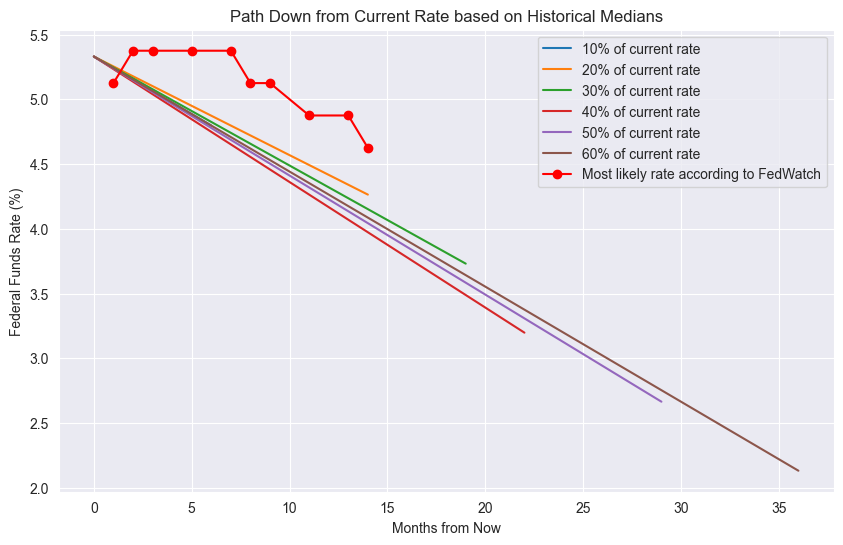

In [52]:
current_rate = fed_funds_rate_combined.loc[fed_funds_rate_combined.index.max(), 'fedfunds']

plt.figure(figsize=(10,6))
plt.title('Path Down from Current Rate based on Historical Medians')
plt.xlabel('Months from Now')
plt.ylabel('Federal Funds Rate (%)')

for i, row in median_std_df.iterrows():
    percentage_label = i.split(' ')[-3]
    print(percentage_label)
    percentage = float(percentage_label.replace('%', '')) / 100
    median_months = row['mean']
    x = np.arange(0, int(median_months) + 1) 
    y = np.linspace(current_rate, current_rate * (1-percentage), len(x))
    plt.plot(x, y, label=f'{percentage_label} of current rate')

plt.plot(result_df['MONTHS FROM NOW'], result_df['MOST LIKELY RATE'], marker='o', linestyle='-', color='red', label='Most likely rate according to FedWatch')

plt.legend()

plt.show()